This code uses XGBOOST for regression.<br>
The algorithm is retrained at every step to predict the next test observation. <br>
The breakpoint detection is done for every test point.<br>
Concept indicators are included as dummies.

In [4]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
import csv
import functions
import json

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [2]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(difference/summation)
    return error

Since now we can't use *ada_preprocessing()* to extract lagged values and concept, because it can potentially mess up breakpoint detection, we need separate function for this.

In [3]:
def manual_preprocessing(values, pattern):
    #receives the list of values up until and including the test point
    
    #extract the column names
    columns = list(pattern.columns)
    
    #append lagged values
    data = [values[-1], values[-2], values[-3], values[-4], values[-5], values[-6]]
    
    #append the same concept dummies as from the last training point
    for i in range(1, list(pattern.columns)[-1]+1):
        data.append(int(pattern.loc[:,i]))
    
    #create the dataframe
    df = pd.DataFrame(columns=columns, data=[data])
    
    return df

In [4]:
def xgboost_forecast(train, test_X):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 40)
    model.fit(train_X, train_y)
    yhat = model.predict(test_X)
    
    return yhat[0]

In [5]:
def one_hot_encoding(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #for now i'm dropping these columns, cause there was no improvement in accuracy
    #by including them so far
    data.drop(["transition", "steps_to_bkp", "steps_since_bkp"], axis = 1, inplace = True)
    
    return data

In [40]:
def plot_save(predictions, actual, bkp, name):
    plt.plot(actual, label = "Expected", color = "black")
    plt.plot(predictions, label = "Predicted", color = "red")
    plt.legend()
    
    #saving the plots
    image_path = name+".png"
    plt.savefig(image_path)
    
    
    #retrieve rows with breakpoints
    bkps = []
    for i in bkp.unique()[1:]:
        bkps.append(np.where(bkp == i)[0][0])
#     print(bkps)
    plt.vlines(x = bkps, ymin = actual.min(), ymax = actual.max(), 
               linestyles = "dashed", color = "deepskyblue", label = "Breakpoints")
    plt.legend()
    image_path = name+"_breakpoints.png"
    plt.savefig(image_path)
    
    bkp_path = name+"_breakpoints.txt"
    with open(bkp_path, 'w') as file:
        file.write(json.dumps("".join([str(j) for j in bkps])))

In [6]:
#takes about an hour for one dataset, so i'm not eager to test on all of them

#so chose the worst performing datasets from xgboost with retrain
list_of_names = ["nonlinear1_abrupt"]

# list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
#                 "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt"]

Time wasted: 92.75m
SMAPE: 0.6068


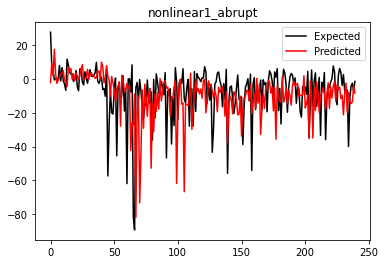

In [7]:
#dictionary to store the overall error
smape_dict = {}

for name in list_of_names:
    start = time.perf_counter()
    
    #loading the data
    file_path = "data/"+name+"_series"
    data = pd.read_csv(file_path).iloc[:,0].to_list()
    
    #70/30 train/test split
    split = int(0.7*len(data))
    train, test = data[:split], data[split:]
    
    predictions = []
    ground_truth = []
    
    for i in range(len(test)):
        #get breakpoints for train
        history = functions.ada_preprocessing(train)
        
        #save the final set of breakpoints
        bkp = None
        if i == len(test)-1:
            bkp = history["concept"]
            
        history = one_hot_encoding(history)
        
        #add new test observation to train series
        train.append(test[i])
        
        #path the last point from history dataframe to then extract same concept dummies
        test_df = manual_preprocessing(train, history.tail(1))
        
        ground_truth.append(train[-1])
        
        #training data = history
        prediction = xgboost_forecast(history, test_df.loc[:,"t-1":])
        predictions.append(prediction)
        
            
    end = time.perf_counter()
    print("Time wasted: {:.2f}m".format((end-start)/60))
    
    error = smape(np.asarray(predictions), np.asarray(ground_truth))
    smape_dict[name] = error
#     print("SMAPE: {:.4f}".format(error))
    plot_save(predictions, ground_truth, bkp, "forecasting_results/xgboost_refedine/"+name)
    
dict_path = "forecasting_results/xgboost_redefine/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict))